## Algerian Forest Fires Dataset 

### Data Set Information:

The dataset includes 244 instances that regroup a data of two regions of Algeria,namely the Bejaia region located in the northeast of Algeria and the Sidi Bel-abbes region located in the northwest of Algeria.

- 122 instances for each region
- The period from June 2012 to September 2012.
- The dataset includes 12 attribues

### Attribute Information:

1. Date : (DD/MM/YYYY) Day, month ('june' to 'september'), year (2012)
Weather data observations
2. Temp : temperature noon (temperature max) in Celsius degrees: 22 to 42
3. RH : Relative Humidity in %: 21 to 90
4. Ws :Wind speed in km/h: 6 to 29
5. Rain: total day in mm: 0 to 16.8
FWI Components
6. Fine Fuel Moisture Code (FFMC) index from the FWI system: 28.6 to 92.5
7. Duff Moisture Code (DMC) index from the FWI system: 1.1 to 65.9
8. Drought Code (DC) index from the FWI system: 7 to 220.4
9. Initial Spread Index (ISI) index from the FWI system: 0 to 18.5
10. Buildup Index (BUI) index from the FWI system: 1.1 to 68
11. Fire Weather Index (FWI) Index: 0 to 31.1
12. Classes: two classes, namely Fire and not Fire

### Problem Statement for this notebook:

Select the best model for the dataset.
- Best performance with linear features
- Minimize the number of features

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.metrics import mean_absolute_error, r2_score

# Data Pre-processing

### Dataset loading

In [64]:
df = pd.read_csv('Algerian_forest_fires_dataset_full.csv')

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Temperature      244 non-null    int64  
 1   RH               244 non-null    int64  
 2   Ws               244 non-null    int64  
 3   Rain             244 non-null    float64
 4   FFMC             244 non-null    float64
 5   DMC              244 non-null    float64
 6   DC               244 non-null    float64
 7   ISI              244 non-null    float64
 8   BUI              244 non-null    float64
 9   FWI              244 non-null    float64
 10  Region_Bejaia    244 non-null    int64  
 11  Region_Sidi_Bel  244 non-null    int64  
dtypes: float64(7), int64(5)
memory usage: 23.0 KB


In [66]:
df.shape

(244, 12)

Get general information about the target feature

In [67]:
df['FWI'].describe()

count    244.000000
mean       7.049180
std        7.428366
min        0.000000
25%        0.700000
50%        4.450000
75%       11.375000
max       31.100000
Name: FWI, dtype: float64

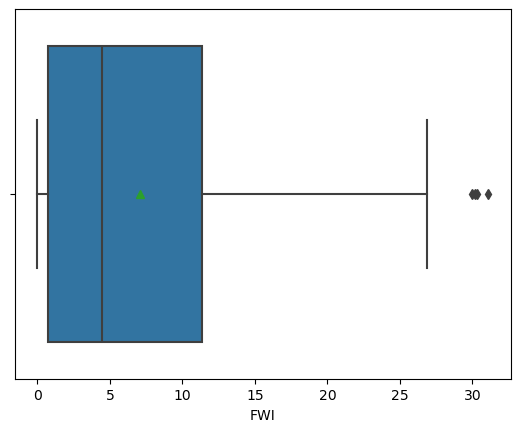

In [68]:
sns.boxplot(x = "FWI", showmeans=True, data=df)
plt.show()

### Feature segregation

In [69]:
## Independent And dependent features
X = df.drop('FWI',axis=1)
y = df['FWI']

In [70]:
X.columns

Index(['Temperature', 'RH', 'Ws', 'Rain', 'FFMC', 'DMC', 'DC', 'ISI', 'BUI',
       'Region_Bejaia', 'Region_Sidi_Bel'],
      dtype='object')

In [71]:
y.shape

(244,)

### Train test split

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [73]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((183, 11), (61, 11), (183,), (61,))

### Feature Scaling
(since linear regression needs scaled features)

In [74]:
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

Text(0.5, 1.0, 'X_train After Scaling')

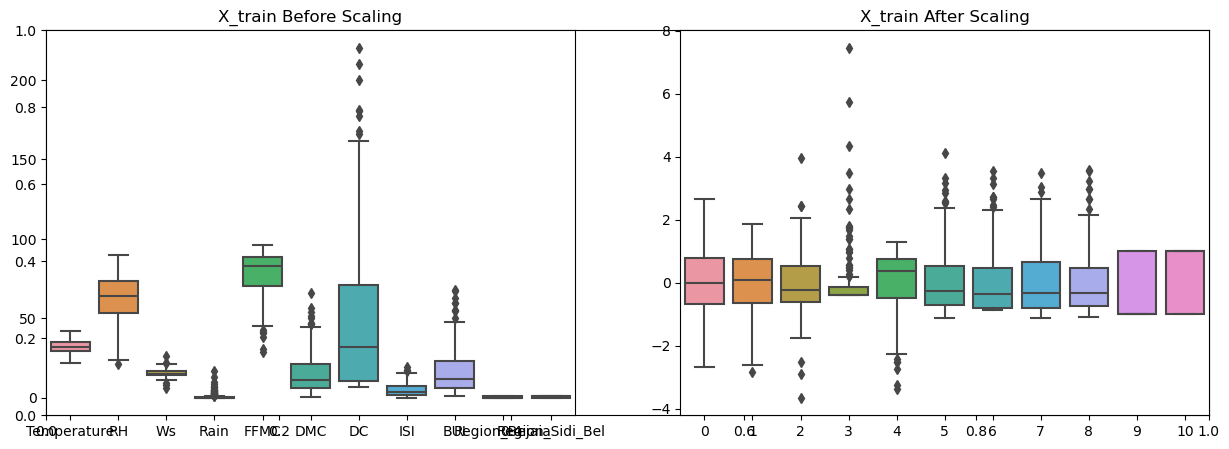

In [75]:
plt.subplots(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.boxplot(data=X_train)
plt.title('X_train Before Scaling')
plt.subplot(1, 2, 2)
sns.boxplot(data=X_train_scaled)
plt.title('X_train After Scaling')

Since the dataset is small, we can proceed with model fitting.

# Model training - Full dataset

### Helper methods

In [76]:
def fit_and_score_regressor(regressor, alpha = None):
    model = regressor()
    if alpha:
        model.alpha = alpha
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, y_pred)
    score = r2_score(y_test, y_pred)
    return model, y_pred, mae, score


In [77]:
def map_model_coeff_to_feature(X, regressor):
    for i, feature in enumerate(X.columns):
        print(f"{feature} --> {regressor.coef_[i]}")

In [78]:
def get_best_r2_scored_model(regressor, regressor_cv):

    # use grid-search 
    alpha_grid = np.linspace(0.001, 0.1, 100)
    grid_search = GridSearchCV(regressor(), param_grid={'alpha':alpha_grid}, cv=5, n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)
    grid_alpha = grid_search.best_params_['alpha']
    grid, grid_pred, grid_mae, grid_score = fit_and_score_regressor(regressor, alpha=round(grid_alpha, 5))
    

    # use model cv
    cv = regressor_cv(cv=5)
    cv.fit(X_train_scaled,y_train)
    cv_alpha = cv.alpha_
    cv_model, cv_pred, cv_mae, cv_score = fit_and_score_regressor(regressor, alpha=cv_alpha)

    if grid_score >= cv_score:
        return grid, grid_pred, grid_mae, grid_score, grid_alpha, "Grid"
    
    return cv_model, cv_pred, cv_mae, cv_score, cv_alpha, "CV"
    

In [79]:
def scatter_plot_generator(y_pred, regressor_name, mae, score, ax):
    ax.scatter(y_test.index, y_test, marker="o", c="blue", label="y_test")
    ax.scatter(y_test.index, y_pred, marker="x", c="green" ,label="y_pred")
    ax.set_xlabel('Index')
    ax.set_ylabel('Values')
    ax.set_title(f"{regressor_name}")
    text_obj = ax.text(80, 27, f"MAE: {mae:.5f}\nR2 Score: {score:.5f}")
    text_obj.set_fontsize(8)
    ax.legend()

### Linear regression

In [80]:
linreg, linereg_pred, linreg_mae, linreg_score = fit_and_score_regressor(LinearRegression)
print("Mean absolute error", linreg_mae)
print("R2 Score", linreg_score)

Mean absolute error 0.5564906134708523
R2 Score 0.9893600002076205


### Observations:
- The R2 score looks good here. Further data processing is not required.
- Model may have been over-fit here.
- Some features may be dropped here, like Temperature.
- Lasso, Ridge or ElasticNet regression will help solve these problems.

### Lasso Regression (L1 regularization)

In [81]:
lasso, ridge_pred, lasso_mae, lasso_score = fit_and_score_regressor(Lasso)
print("Mean absolute error", lasso_mae)
print("R2 Score", lasso_score)

Mean absolute error 1.1928573187943743
R2 Score 0.9507758047055624


### Ridge Regression (L2 regularization)

In [82]:
ridge, ridge_pred, ridge_mae, ridge_score = fit_and_score_regressor(Ridge)
print("Mean absolute error", ridge_mae)
print("R2 Score", ridge_score)

Mean absolute error 0.5661862351736467
R2 Score 0.9893473842040333


### ElasticNet Regression (L1 and L2 regularization)

In [83]:
elastic, elastic_pred, elastic_mae, elastic_score = fit_and_score_regressor(ElasticNet)
print("Mean absolute error", elastic_mae)
print("R2 Score", elastic_score)

Mean absolute error 1.8155802559748508
R2 Score 0.8935478770527324


Observations:
- Ridge regression seems to be the best model right now.
- We can use cross-validation to get a better set of hyperparameters

# Hyper-parameter Tuning

In [84]:
lasso_model, lasso_pred, lasso_mae, lasso_score, lasso_alpha, cv_type = get_best_r2_scored_model(Lasso, LassoCV)
lasso_mae, lasso_score, lasso_alpha, cv_type

(0.583945171556199, 0.9879537713922529, 0.03336823840603751, 'CV')

In [85]:
ridge_model, ridge_pred, ridge_mae, ridge_score, ridge_alpha, cv_type = get_best_r2_scored_model(Ridge, RidgeCV)
ridge_mae, ridge_score, ridge_alpha, cv_type

(0.5561302730949308, 0.9894442392112307, 0.1, 'CV')

In [86]:
elasticnet_model, elasticnet_pred, elasticnet_mae, elasticnet_score, elasticnet_alpha, cv_type = get_best_r2_scored_model(ElasticNet, ElasticNetCV)
elasticnet_mae, elasticnet_score, elasticnet_alpha, cv_type

(0.5562634138139096, 0.9894578043110405, 0.002, 'Grid')

### Observations:
- Given the low alpha values of lasso and elasticnet, their performance will be similar to linear regression.
- Ridge regression looks like the best fit, given a higher alpha value.

# Finalize Model

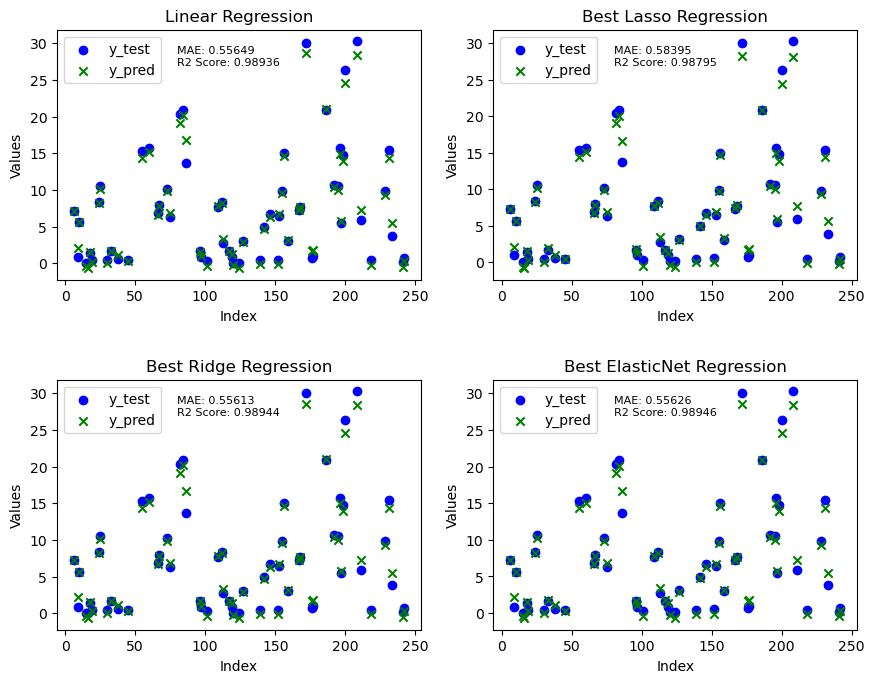

In [87]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

scatter_plot_generator(linereg_pred, "Linear Regression", linreg_mae, linreg_score, axes[0, 0])
scatter_plot_generator(lasso_pred, "Best Lasso Regression", lasso_mae, lasso_score, axes[0, 1])
scatter_plot_generator(ridge_pred, "Best Ridge Regression", ridge_mae, ridge_score, axes[1, 0])
scatter_plot_generator(elasticnet_pred, "Best ElasticNet Regression", elasticnet_mae, elasticnet_score, axes[1, 1])

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.85, wspace=0.2, hspace=0.4)

plt.show()


In [88]:
map_model_coeff_to_feature(X, linreg)

Temperature --> -0.015585282540914153
RH --> -0.041466752085035995
Ws --> -0.03646136584676876
Rain --> 0.022000373148294002
FFMC --> -0.6379765924309547
DMC --> -0.24384209337849483
DC --> -0.6090663380503583
ISI --> 4.868561046918288
BUI --> 4.436839684183857
Region_Bejaia --> 0.06337814500718357
Region_Sidi_Bel --> -0.06337814500718168


In [89]:
map_model_coeff_to_feature(X, lasso_model)

Temperature --> -0.0
RH --> -0.0
Ws --> -0.0
Rain --> 0.029828158764608176
FFMC --> -0.4786655777630092
DMC --> 0.4061351915959897
DC --> 0.0
ISI --> 4.802176701537208
BUI --> 3.1410357461774354
Region_Bejaia --> 0.05118698164887643
Region_Sidi_Bel --> -1.854011783199168e-15


In [90]:
map_model_coeff_to_feature(X, ridge_model)

Temperature --> -0.01801555277969684
RH --> -0.04230989041283877
Ws --> -0.034184129066667526
Rain --> 0.023970025518984885
FFMC --> -0.6271026352796596
DMC --> -0.028880094000242936
DC --> -0.5083038378909039
ISI --> 4.864649208464904
BUI --> 4.1266122498017985
Region_Bejaia --> 0.06638528187203238
Region_Sidi_Bel --> -0.06638528187215888


In [91]:
map_model_coeff_to_feature(X, elasticnet_model)

Temperature --> -0.017570754124156398
RH --> -0.040368236694762256
Ws --> -0.030611552777051663
Rain --> 0.02614177654284142
FFMC --> -0.6142024516802276
DMC --> 0.15657896196349821
DC --> -0.40188652025667193
ISI --> 4.8605940320634415
BUI --> 3.837755568865111
Region_Bejaia --> 0.0812894269821247
Region_Sidi_Bel --> -0.05199347238274403


### Observations
- The MAE and R2_score of the models are almost the same, we need to select the model as per other requirements.
- Lasso model with alpha = 0.03336823840603751 seems to be the best fit model, as it has minimized the number of features by 4


# Finalize model and Export

In [92]:
X = df.drop(['FWI', 'Temperature', 'RH', 'Ws', 'DC'],axis=1)
y = df['FWI']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [93]:
X.head()

,Rain,FFMC,DMC,ISI,BUI,Region_Bejaia,Region_Sidi_Bel
0,0.0,65.7,3.4,1.3,3.4,1,0
1,1.3,64.4,4.1,1.0,3.9,1,0
2,13.1,47.1,2.5,0.3,2.7,1,0
3,2.5,28.6,1.3,0.0,1.7,1,0
4,0.0,64.8,3.0,1.2,3.9,1,0


In [94]:
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [95]:
model = Lasso(alpha=0.03336823840603751)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
score = r2_score(y_test, y_pred)
mae, score

(0.5839439846471203, 0.9879539089429508)

### Model Export

In [96]:
scaler

StandardScaler()

In [97]:
lasso_model

Lasso(alpha=0.03336823840603751)

In [98]:
import pickle
pickle.dump(scaler, open('scaler.pkl', 'wb'))
pickle.dump(model, open('model.pkl', 'wb'))

# Finished!!!